In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import tensorflow as tf

In [2]:
heat = pd.read_csv("heat_energy.csv")

In [3]:
import datetime
heat.date=heat.date.apply(lambda x:datetime.datetime.strptime(x, '%m/%d/%Y'))

In [157]:
search_error = heat.loc[(heat['date'] == '2016-11-01') | (heat['date'] == '2017-11-01') | (heat['date'] == '2018-11-01') | (heat['date'] == '2019-11-01') | (heat['date'] == '2021-11-01')]

In [158]:
val = search_error['value_gc'].mean()

In [159]:
heat.loc[57, 'value_gc'] = val

In [234]:
heat.index = heat.date

In [237]:
del heat['date']

In [240]:
heat

,value_gc
date,
2016-02-01,12000
2016-03-01,10110
2016-04-01,8800
2016-05-01,2900
2016-06-01,1000
...,...
2021-08-01,954
2021-09-01,954
2021-10-01,827


In [160]:
df_heat = heat.value_gc
df_heat.index = heat['date']

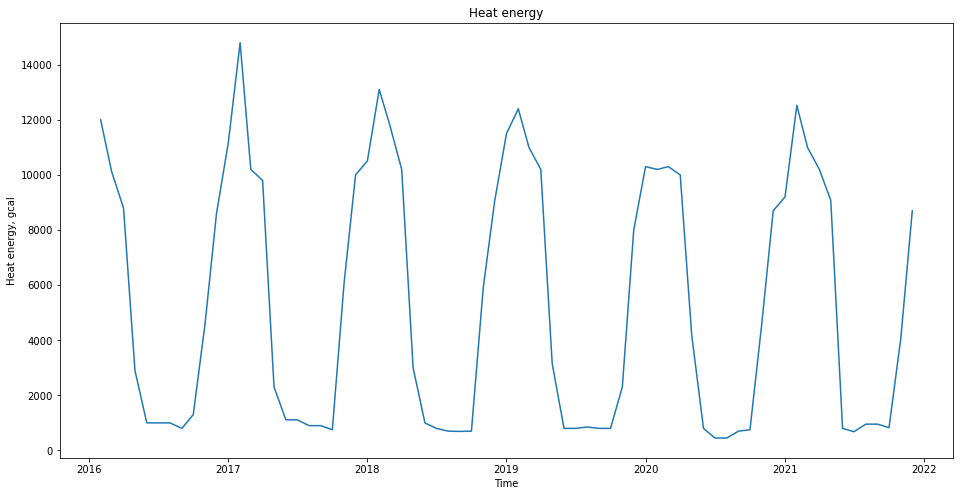

In [161]:
plt.figure(figsize=(16,8))
plt.title('Heat energy')
plt.xlabel('Time')
plt.ylabel('Heat energy, gcal')
plt.plot(df_heat)
plt.show()

In [162]:
train_split = 45

In [163]:
heat_train_mean = df_heat[:train_split].mean()
heat_train_std = df_heat[:train_split].std()

In [164]:
heat_data = (df_heat - heat_train_mean) / heat_train_std

In [165]:
heat_data = heat_data.values

In [166]:
frame = heat.copy()
frame.index = frame.date
del frame['date']

In [167]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [168]:
univariate_past_history = 14
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(heat_data, 0, train_split,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(heat_data, train_split, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [169]:
len(y_val_uni)

12

In [170]:
def create_time_steps(length):
    return list(range(-length, 0))

In [171]:
def show_plot(plot_data, delta, title):
    labels = ['История', 'Истинное будущее значение', 'Базовое предсказание']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Временной интервал')
    return plt

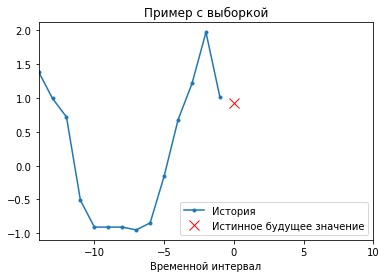

In [172]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')
plt.show()

In [173]:
print(create_time_steps([x_train_uni[0], y_train_uni[0]][0].shape[0]))

[-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]


In [174]:
def baseline(history):
    return np.mean(history)

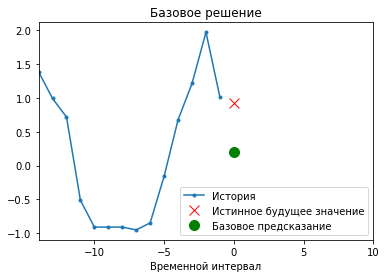

In [175]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Базовое решение')
plt.show()

In [176]:
batch_size = 1
buffer_size = 10

In [177]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(buffer_size).batch(batch_size).repeat()

In [178]:
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(batch_size).repeat()

In [198]:
x_test = heat_data[-14:]
for_1_prediction = tf.data.Dataset.from_tensor_slices(x_test)
for_1_prediction = for_1_prediction.batch(batch_size)

In [206]:
lst = []
for i in x_test:
    lst.append([i])

In [209]:
lst1 = []   
lst1 = [lst]

[[[-0.15803395529911823],
  [0.6976105408925996],
  [0.8019065545678454],
  [1.4952664534808806],
  [1.1773722037987309],
  [1.0104985819183374],
  [0.7779184714225389],
  [-0.9502664751762865],
  [-0.9752975184583454],
  [-0.9181433029643107],
  [-0.9181433029643107],
  [-0.9446344904378232],
  [-0.2639987051931681],
  [0.6976105408925996]]]

In [203]:
x_val_uni

array([[[-0.63737843],
        [ 0.55159612],
        [ 1.03135778],
        [ 1.01049858],
        [ 1.03135778],
        [ 0.96878018],
        [-0.24105358],
        [-0.95026648],
        [-1.02327368],
        [-1.02327368],
        [-0.97112568],
        [-0.96069608],
        [-0.15803396],
        [ 0.69761054]],

       [[ 0.55159612],
        [ 1.03135778],
        [ 1.01049858],
        [ 1.03135778],
        [ 0.96878018],
        [-0.24105358],
        [-0.95026648],
        [-1.02327368],
        [-1.02327368],
        [-0.97112568],
        [-0.96069608],
        [-0.15803396],
        [ 0.69761054],
        [ 0.80190655]],

       [[ 1.03135778],
        [ 1.01049858],
        [ 1.03135778],
        [ 0.96878018],
        [-0.24105358],
        [-0.95026648],
        [-1.02327368],
        [-1.02327368],
        [-0.97112568],
        [-0.96069608],
        [-0.15803396],
        [ 0.69761054],
        [ 0.80190655],
        [ 1.49526645]],

       [[ 1.01049858],
     

In [180]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])
simple_lstm_model.compile(optimizer='adam', loss='mae')

In [181]:
x_train_uni.shape

(31, 14, 1)

In [182]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(1, 1)


In [183]:
EVALUATION_INTERVAL = 200
EPOCHS = 20
single_step_history= simple_lstm_model.fit(train_univariate, epochs = EPOCHS,
                      steps_per_epoch = EVALUATION_INTERVAL,
                      validation_data = val_univariate, validation_steps = 50)

Epoch 1/20
200/200 [==============================] - 2s 6ms/step - loss: 0.8248 - val_loss: 0.7192
Epoch 2/20
200/200 [==============================] - 1s 5ms/step - loss: 0.5271 - val_loss: 0.5011
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.3758 - val_loss: 0.2720
Epoch 4/20
200/200 [==============================] - 1s 5ms/step - loss: 0.2027 - val_loss: 0.2258
Epoch 5/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1745 - val_loss: 0.2459
Epoch 6/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1552 - val_loss: 0.2331
Epoch 7/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1354 - val_loss: 0.2357
Epoch 8/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1214 - val_loss: 0.2163
Epoch 9/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1074 - val_loss: 0.2195
Epoch 10/20
200/200 [==============================] - 1s 5ms/step - loss: 0.1003 - val_loss: 0.2127

In [184]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(8,5))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel("Loss")

    plt.show()

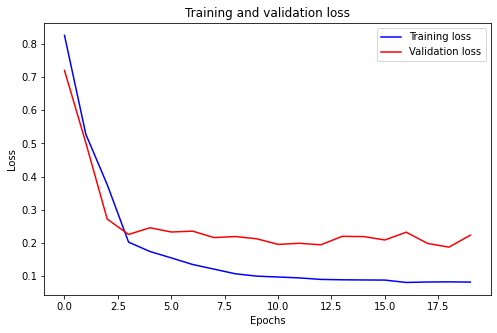

In [185]:
plot_train_history(single_step_history,
                   'Training and validation loss')

Обратное преобразование

In [186]:
x_val_uni.shape

(12, 14, 1)

<RepeatDataset shapes: ((None, 14, 1), (None,)), types: (tf.float64, tf.float64)>

In [187]:
lst_y = []
lst_predict = []
for x, y in val_univariate.take(12):
    predict = simple_lstm_model.predict(x) * heat_train_std + heat_train_mean
    y = y.numpy() * heat_train_std + heat_train_mean
    x = x.numpy() * heat_train_std + heat_train_mean
    lst_y.append(y)
    lst_predict.append(predict)
    print(y, predict)

[9200.] [[11442.984]]
[12524.] [[12083.532]]
[11000.] [[11872.0205]]
[10200.] [[10000.34]]
[9085.] [[3507.8599]]
[800.] [[862.7954]]
[680.] [[640.8301]]
[954.] [[879.52734]]
[954.] [[653.1743]]
[827.] [[553.16406]]
[4090.] [[2516.9646]]
[8700.] [[7628.1387]]


In [188]:
ls_y = []
for i in lst_y:
    for j in i:
        ls_y.append(j)

In [105]:
ls_y

[9200.0,
 12524.0,
 11000.0,
 10200.0,
 9085.0,
 800.0,
 680.0,
 954.0,
 954.0,
 827.0,
 4090.0,
 8700.0]

In [189]:
ls_predict = []
for i in lst_predict:
    for j in i:
        for k in j:
            ls_predict.append(k)

In [107]:
ls_predict

[11522.863,
 12588.915,
 12323.842,
 10427.865,
 3310.2593,
 1832.4724,
 924.97217,
 751.32764,
 698.37354,
 595.8364,
 3698.345,
 7718.9614]

In [191]:
del ls_y[4]
del ls_predict[4]

In [192]:
real = pd.DataFrame(ls_y)
prognoz = pd.DataFrame(ls_predict)

In [193]:
real['e'] = real[0] - prognoz[0]
real['p'] = 100*real['e']/real[0]
print ('MAPE', np.mean(abs(real['p']))) #cредняя абсолютная ошибка нашего прогноза в процентах mean absolute percentage error
print ('MAE', np.mean(abs(real['e'])))

MAPE 15.874914137847185
MAE 650.1026500355114


Предсказание на декабрь 2021:

In [214]:
simple_lstm_model.predict(lst1) * heat_train_std + heat_train_mean

array([[10854.262]], dtype=float32)

Для рисования предсказаний тестовой выборки:

На стандартизированных данных:

[array([[-0.63737843],
       [ 0.55159612],
       [ 1.03135778],
       [ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054]]), 0.8019065545678454, array([1.3007323], dtype=float32)]


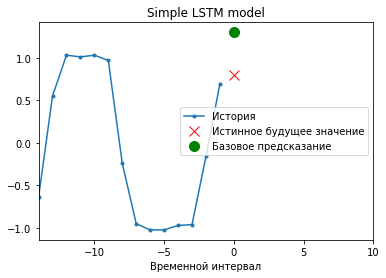

[array([[ 0.55159612],
       [ 1.03135778],
       [ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655]]), 1.4952664534808806, array([1.5174943], dtype=float32)]


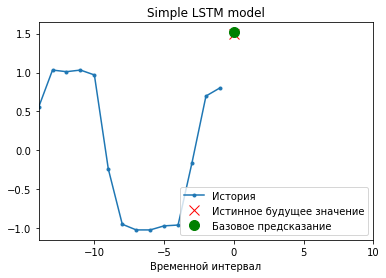

[array([[ 1.03135778],
       [ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645]]), 1.1773722037987309, array([1.4589099], dtype=float32)]


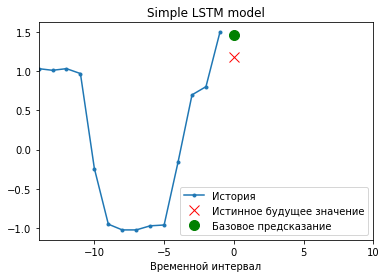

[array([[ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ]]), 1.0104985819183374, array([1.0189973], dtype=float32)]


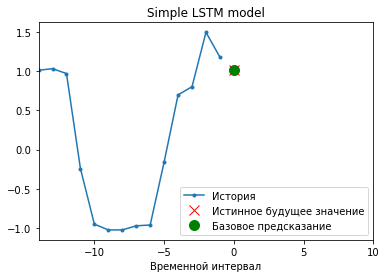

[array([[ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858]]), 0.7779184714225389, array([-0.48499033], dtype=float32)]


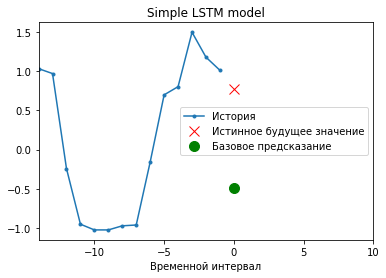

[array([[ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847]]), -0.9502664751762865, array([-0.7756149], dtype=float32)]


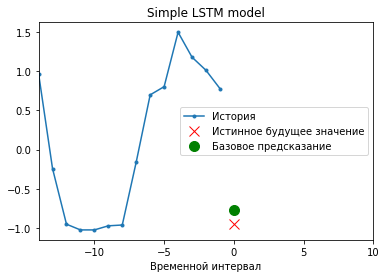

[array([[-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648]]), -0.9752975184583454, array([-0.94349325], dtype=float32)]


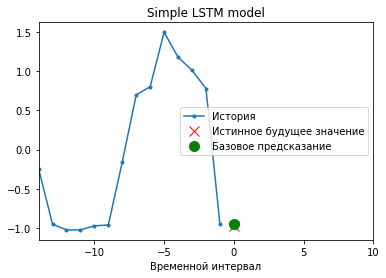

[array([[-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752]]), -0.9181433029643107, array([-0.9689741], dtype=float32)]


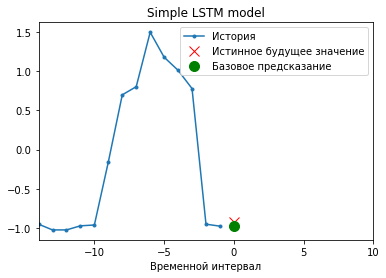

[array([[-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752],
       [-0.9181433 ]]), -0.9181433029643107, array([-0.97570145], dtype=float32)]


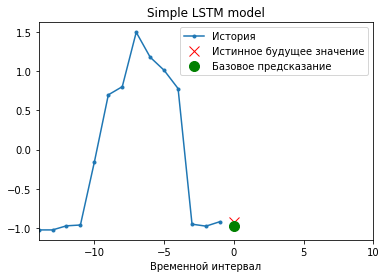

[array([[-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752],
       [-0.9181433 ],
       [-0.9181433 ]]), -0.9446344904378232, array([-1.0161328], dtype=float32)]


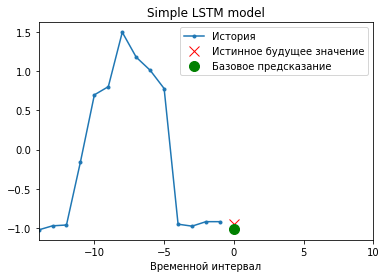

[array([[-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752],
       [-0.9181433 ],
       [-0.9181433 ],
       [-0.94463449]]), -0.2639987051931681, array([-0.26584315], dtype=float32)]


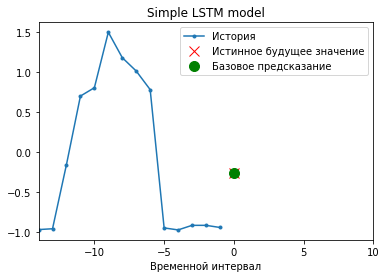

[array([[-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752],
       [-0.9181433 ],
       [-0.9181433 ],
       [-0.94463449],
       [-0.26399871]]), 0.6976105408925996, array([0.54742193], dtype=float32)]


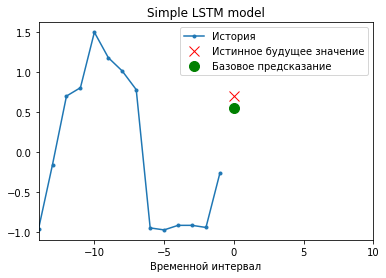

[array([[-0.63737843],
       [ 0.55159612],
       [ 1.03135778],
       [ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054]]), 0.8019065545678454, array([1.3007323], dtype=float32)]


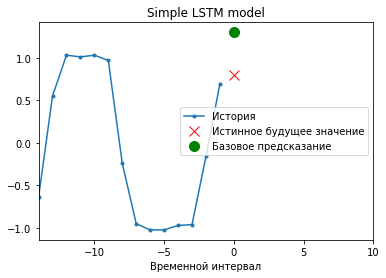

[array([[ 0.55159612],
       [ 1.03135778],
       [ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655]]), 1.4952664534808806, array([1.5174943], dtype=float32)]


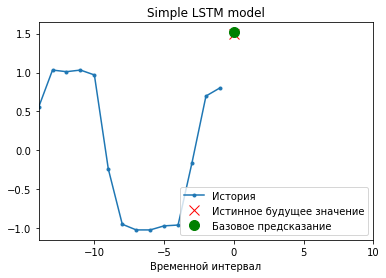

[array([[ 1.03135778],
       [ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645]]), 1.1773722037987309, array([1.4589099], dtype=float32)]


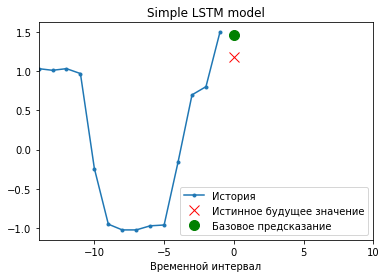

[array([[ 1.01049858],
       [ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ]]), 1.0104985819183374, array([1.0189973], dtype=float32)]


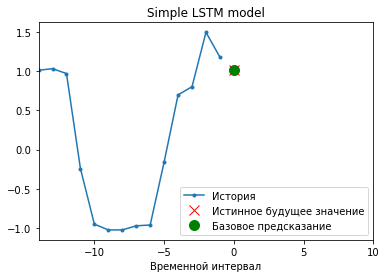

[array([[ 1.03135778],
       [ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858]]), 0.7779184714225389, array([-0.48499033], dtype=float32)]


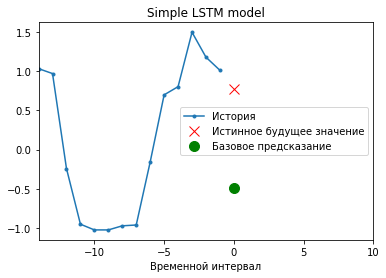

[array([[ 0.96878018],
       [-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847]]), -0.9502664751762865, array([-0.7756149], dtype=float32)]


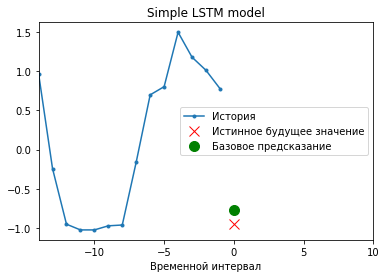

[array([[-0.24105358],
       [-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648]]), -0.9752975184583454, array([-0.94349325], dtype=float32)]


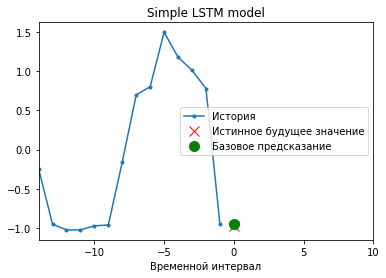

[array([[-0.95026648],
       [-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752]]), -0.9181433029643107, array([-0.9689741], dtype=float32)]


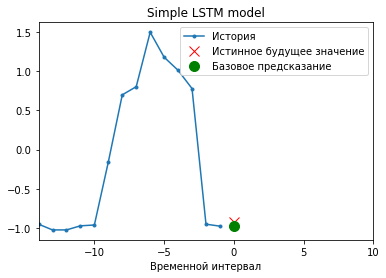

[array([[-1.02327368],
       [-1.02327368],
       [-0.97112568],
       [-0.96069608],
       [-0.15803396],
       [ 0.69761054],
       [ 0.80190655],
       [ 1.49526645],
       [ 1.1773722 ],
       [ 1.01049858],
       [ 0.77791847],
       [-0.95026648],
       [-0.97529752],
       [-0.9181433 ]]), -0.9181433029643107, array([-0.97570145], dtype=float32)]


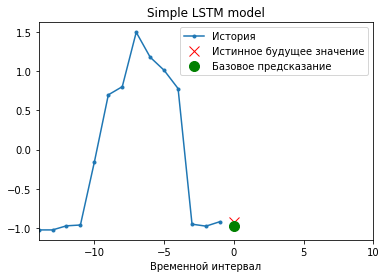

In [93]:
for x, y in val_univariate.take(21):
    print([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]])
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

In [94]:
[x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]]

[array([[-1.02327368],
        [-1.02327368],
        [-0.97112568],
        [-0.96069608],
        [-0.15803396],
        [ 0.69761054],
        [ 0.80190655],
        [ 1.49526645],
        [ 1.1773722 ],
        [ 1.01049858],
        [ 0.77791847],
        [-0.95026648],
        [-0.97529752],
        [-0.9181433 ]]),
 -0.9181433029643107,
 array([-0.97570145], dtype=float32)]

На реальных данных:

In [225]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'The true future value', 'Model prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time')
    return plt

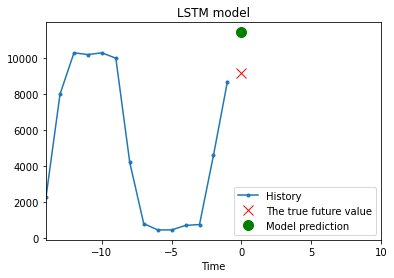

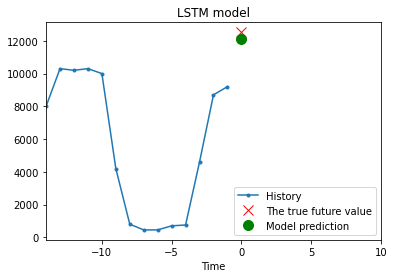

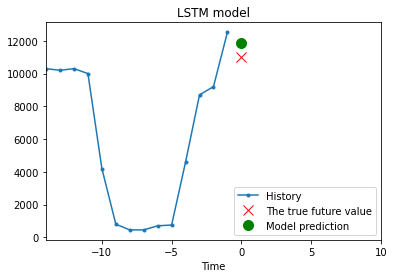

In [227]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy() * heat_train_std + heat_train_mean, y[0].numpy() * heat_train_std + heat_train_mean,
                    simple_lstm_model.predict(x)[0]* heat_train_std + heat_train_mean], 0, 'LSTM model')
    plot.show()

In [222]:
real

,0,e,p
0,9200.0,-2242.984375,-24.380265
1,12524.0,440.467773,3.516990
2,11000.0,-872.020508,-7.927459
3,10200.0,199.660156,1.957453
4,800.0,-62.795410,-7.849426
5,680.0,39.169922,5.760283
6,954.0,74.472656,7.806358
7,954.0,300.825684,31.533091
8,827.0,273.835938,33.111963
9,4090.0,1573.035400,38.460523


In [223]:
prognoz

,0
0,11442.984375
1,12083.532227
2,11872.020508
3,10000.339844
4,862.795410
5,640.830078
6,879.527344
7,653.174316
8,553.164062
9,2516.964600
